<a href="https://colab.research.google.com/github/CS7140/PA-7/blob/main/Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rajesh Sakhamuru

11-7-2020
# Dropout vs Batch Norm Performance Comparison

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
with strategy.scope():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

    train_labels = tf.convert_to_tensor(train_labels)
    test_labels = tf.convert_to_tensor(test_labels)

    train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
    test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

    # resizes images and pads resized image with 0s so convolutions+pooling don't shrink
    # resolution too much
    train_images = tf.image.resize_with_pad(train_images, 112, 112)
    test_images = tf.image.resize_with_pad(test_images, 112, 112)

    train_images = tf.convert_to_tensor((train_images) / 255)
    test_images = tf.convert_to_tensor((test_images) / 255)


In [23]:
def alexNetNoNorms(lr=0.01):
    alexNet = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    alexNet.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return alexNet

In [22]:
def alexNetDropout(lr=0.01):
    alexNet = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10)
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    alexNet.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return alexNet

In [26]:
def alexNetBatchNorm(lr=0.01):
    alexNet = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10)
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    alexNet.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return alexNet

In [5]:
def plotAccuracyAndLoss(history, epochs):
    plt.title("Train vs Test Accuracy over Epochs")
    plt.plot(range(1,epochs+1), history.history['accuracy'], 'b-', label='train accuracy')
    plt.plot(range(1,epochs+1), history.history['val_accuracy'], 'r-', label='test accuracy')
    plt.ylabel("accuracy")
    plt.xlabel("epoch number")
    plt.legend()
    plt.show()

    plt.title("Train vs Test Loss over Epochs")
    plt.plot(range(1,epochs+1), history.history['loss'], 'b-', label='train loss')
    plt.plot(range(1,epochs+1), history.history['val_loss'], 'r-', label='test loss')
    plt.ylabel("loss")
    plt.xlabel("epoch number")
    plt.legend()
    plt.show()

Below we have three implementations of alexNet. One with no normalization, one with dropout and one with batch normalization. 

As we can see with no normalization, after ~15 epochs the test loss begins to increase and accuracy decreases indicating overfitting. We can conclude that without normalization, alexNet will overfit.

With dropout, we can see that any sign of overfitting is no longer apparent and that testing and training accuracy increases together and loss decreases together. There is no sudden decrease in accuracy or increase in loss indicating overfitting. The testing and training curves move together at each epoch keeping very similar values even at 20 epochs.

When dropout is replaced with batch normalization, overfitting is decreased but not as thoroughly effective as dropout. After 18 epochs there is a slight but significant increase in testing loss and decrease in testing accuracy. We can see that because of batch normalization the testing accuracy stabilizes at around 91% and is significantly improved over the implementation with no normalization at all and in terms of testing performance, performs similarly to the model using dropout. The batch normalization model also learns much faster than the other two models.

Conclusively, we can replace dropout with batch normalization but will normalize with differing results. Both achieve normalization via different methods. When using dropout, nodes are randomly dropped which generates noise during training which prevents overfitting to the training data. This is why we see the train and test curves closely matching each other. Batch normalization works by normalizing layer inputs and improving optimization of weights. As a side effect of this some noise is generated and so overfitting to the training data is slightly prevented and testing accuracy is not drastically harmed.

### With No Normalization at all, no dropout or batch normalization:

In [20]:
with strategy.scope():
    alexNetNoNormalization = alexNetNoNorms(lr=0.01)
    history1 = alexNetNoNormalization.fit(train_images, train_labels, epochs=20, batch_size=64, validation_data=(test_images, test_labels), verbose=2)

Epoch 1/20
938/938 - 21s - loss: 1.1848 - accuracy: 0.5707 - val_loss: 0.8188 - val_accuracy: 0.7073
Epoch 2/20
938/938 - 20s - loss: 0.6100 - accuracy: 0.7696 - val_loss: 0.5566 - val_accuracy: 0.7962
Epoch 3/20
938/938 - 20s - loss: 0.5004 - accuracy: 0.8109 - val_loss: 0.5070 - val_accuracy: 0.8043
Epoch 4/20
938/938 - 20s - loss: 0.4393 - accuracy: 0.8354 - val_loss: 0.4568 - val_accuracy: 0.8307
Epoch 5/20
938/938 - 20s - loss: 0.4013 - accuracy: 0.8506 - val_loss: 0.4235 - val_accuracy: 0.8440
Epoch 6/20
938/938 - 20s - loss: 0.3713 - accuracy: 0.8608 - val_loss: 0.4448 - val_accuracy: 0.8287
Epoch 7/20
938/938 - 20s - loss: 0.3478 - accuracy: 0.8711 - val_loss: 0.3470 - val_accuracy: 0.8723
Epoch 8/20
938/938 - 20s - loss: 0.3292 - accuracy: 0.8774 - val_loss: 0.3626 - val_accuracy: 0.8600
Epoch 9/20
938/938 - 20s - loss: 0.3125 - accuracy: 0.8841 - val_loss: 0.3422 - val_accuracy: 0.8692
Epoch 10/20
938/938 - 20s - loss: 0.2967 - accuracy: 0.8891 - val_loss: 0.3360 - val_accura

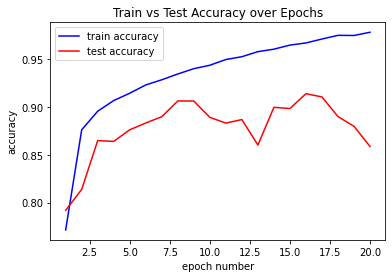

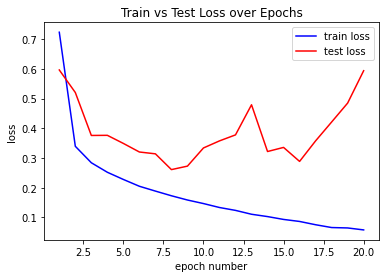

In [17]:
plotAccuracyAndLoss(history1,20) # With no normalization

### With Dropout:

Epoch 1/20
938/938 - 21s - loss: 1.7045 - accuracy: 0.3291 - val_loss: 0.9206 - val_accuracy: 0.6314
Epoch 2/20
938/938 - 20s - loss: 0.8320 - accuracy: 0.6796 - val_loss: 0.7214 - val_accuracy: 0.7153
Epoch 3/20
938/938 - 20s - loss: 0.6616 - accuracy: 0.7491 - val_loss: 0.5947 - val_accuracy: 0.7726
Epoch 4/20
938/938 - 20s - loss: 0.5783 - accuracy: 0.7817 - val_loss: 0.5434 - val_accuracy: 0.7979
Epoch 5/20
938/938 - 20s - loss: 0.5256 - accuracy: 0.8005 - val_loss: 0.4956 - val_accuracy: 0.8044
Epoch 6/20
938/938 - 20s - loss: 0.4831 - accuracy: 0.8183 - val_loss: 0.5005 - val_accuracy: 0.7979
Epoch 7/20
938/938 - 20s - loss: 0.4505 - accuracy: 0.8316 - val_loss: 0.4194 - val_accuracy: 0.8418
Epoch 8/20
938/938 - 20s - loss: 0.4239 - accuracy: 0.8421 - val_loss: 0.4214 - val_accuracy: 0.8405
Epoch 9/20
938/938 - 20s - loss: 0.3980 - accuracy: 0.8536 - val_loss: 0.3706 - val_accuracy: 0.8645
Epoch 10/20
938/938 - 20s - loss: 0.3752 - accuracy: 0.8623 - val_loss: 0.3581 - val_accura

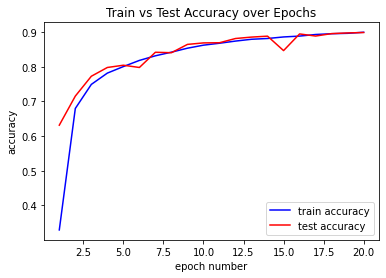

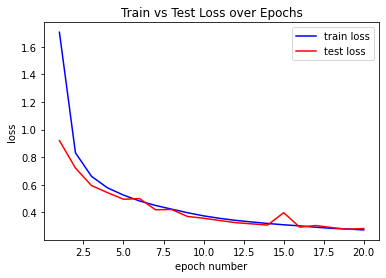

In [24]:
with strategy.scope():
    alexNetWithDropout = alexNetDropout(lr=0.01)
    history2 = alexNetWithDropout.fit(train_images, train_labels, epochs=20, batch_size=64, validation_data=(test_images, test_labels), verbose=2)
    plotAccuracyAndLoss(history2,20)

### With Batch Normalization Replacing Dropout:

Epoch 1/20
938/938 - 22s - loss: 0.5878 - accuracy: 0.8159 - val_loss: 0.5520 - val_accuracy: 0.8078
Epoch 2/20
938/938 - 21s - loss: 0.3129 - accuracy: 0.8844 - val_loss: 0.3495 - val_accuracy: 0.8737
Epoch 3/20
938/938 - 21s - loss: 0.2577 - accuracy: 0.9058 - val_loss: 0.3416 - val_accuracy: 0.8731
Epoch 4/20
938/938 - 21s - loss: 0.2196 - accuracy: 0.9187 - val_loss: 0.2918 - val_accuracy: 0.8959
Epoch 5/20
938/938 - 21s - loss: 0.1931 - accuracy: 0.9265 - val_loss: 0.2773 - val_accuracy: 0.9063
Epoch 6/20
938/938 - 21s - loss: 0.1717 - accuracy: 0.9359 - val_loss: 0.2838 - val_accuracy: 0.9018
Epoch 7/20
938/938 - 21s - loss: 0.1514 - accuracy: 0.9435 - val_loss: 0.2606 - val_accuracy: 0.9119
Epoch 8/20
938/938 - 21s - loss: 0.1321 - accuracy: 0.9500 - val_loss: 0.2807 - val_accuracy: 0.9057
Epoch 9/20
938/938 - 21s - loss: 0.1182 - accuracy: 0.9556 - val_loss: 0.2995 - val_accuracy: 0.9019
Epoch 10/20
938/938 - 21s - loss: 0.1023 - accuracy: 0.9617 - val_loss: 0.3642 - val_accura

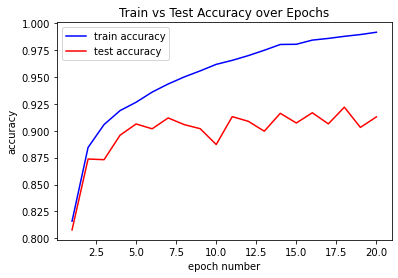

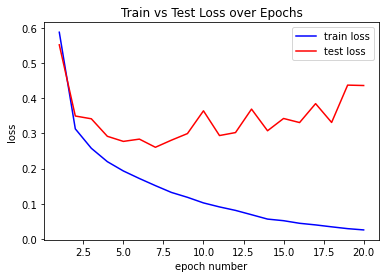

In [27]:
with strategy.scope():
    alexNetWithBatchNorm = alexNetBatchNorm(lr=0.01)
    history3 = alexNetWithBatchNorm.fit(train_images, train_labels, epochs=20, batch_size=64, validation_data=(test_images, test_labels), verbose=2)
    plotAccuracyAndLoss(history3,20)